# Contrastive Learning

In [29]:
batch_size = 2
model_name = "CLR - 01"

In [30]:
%%capture
!pip install torch torchvision

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.functional import cosine_similarity
import torchvision.transforms.functional as TF
import torch.optim as optim
from tqdm import tqdm
import time
import csv

In [32]:
torch.cuda.empty_cache()

In [33]:
%%capture
# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Usual transformations
transform_load = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Data augmentation
def get_transformed_augmented(val):
    if val < 0.5:
        return transforms.Compose([
        transforms.RandomResizedCrop(size=224 ,scale=(0.7, 1.0), ratio=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(0.3),
    ])
    return transforms.Compose([
        transforms.RandomHorizontalFlip(0.3),
        transforms.ColorJitter(brightness=0.1, contrast=0.1,
                                  saturation=0.1, hue=0.05)
    ])

# Get the subset dataset and calculate the mean and std
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_load)
train_size = 5000
subset_indices = np.random.choice(len(train_dataset), train_size, replace=False)
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_load)

In [34]:
# Data augmentation
def get_transforms(means, stds):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds),
    ])
    return transform

# Calculate the mean and std of the subset dataset
def get_mean_std(dataset):
    """Compute the mean and std value of dataset."""
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:, i, :, :].mean()
            std[i] += inputs[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [35]:
# Calculate the mean and std of the subset dataset
train_means, train_stds = get_mean_std(subset_dataset)
print(f'Means: {train_means}')
print(f'Standard deviations: {train_stds}\n')
val_means, val_stds = get_mean_std(val_dataset)
print(f'Validation means: {val_means}')
print(f'Validation standard deviations: {val_stds}')

==> Computing mean and std..
Means: tensor([0.4902, 0.4795, 0.4439])
Standard deviations: tensor([0.1948, 0.1929, 0.1945])

==> Computing mean and std..
Validation means: tensor([0.4942, 0.4851, 0.4504])
Validation standard deviations: tensor([0.1949, 0.1922, 0.1944])


In [36]:
%%capture
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means,train_stds))
train_size = 5000
subset_indices = np.random.choice(len(train_dataset), train_size, replace=False)
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means,val_stds))

# Data Loader
train_loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

## Contrastive Model

In [37]:
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, z1, z2, z_list):
        # Calculate cosine similarity
        similarity_pair = cosine_similarity(z1, z2, dim=-1) / self.temperature

        # Calculate the cosine similarity for each pair of z1 and... but not z1 and z1
        similarities = torch.stack([cosine_similarity(z1, rep, dim=-1) / self.temperature for rep in z_list if not torch.equal(rep, z1)])
        
        if similarities.numel() == 0:
            return torch.tensor(0.0, device=z1.device, requires_grad=True)
        
        # Numerator is exp(similarity_pair)
        exp_similarity = torch.exp(similarity_pair)

        # Denominator is sum(exp(list_similarity_pair))
        exp_similarities = torch.sum(torch.exp(similarities))

        # Apply log-sum-exp trick
        loss = -torch.log(exp_similarity / (exp_similarities + exp_similarity))
        
        if torch.isnan(loss):
            return torch.tensor(0.0, device=z1.device, requires_grad=True)
            
        return torch.mean(loss)  # Compute the mean of the loss

In [38]:
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model


    def forward(self, x1, x2):
        z1 = self.base_model(x1)
        z2 = self.base_model(x2)
        return z1, z2

In [39]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        self.resnet = torchvision.models.resnet18()
        self.resnet.fc = nn.Identity()

    def forward(self, x):
        return self.resnet(x)

In [40]:
model = SiameseNetwork(SimpleResNet())
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = ContrastiveLoss()

In [41]:
%%capture
num_epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [42]:
loss_history = []
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, data in enumerate(train_loader):

        images, _ = data
        images = images.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Initialize total loss for the batch
        batch_loss = torch.tensor(0.0, device=device, requires_grad=True)

        # Create tuples of transformed images for each image of the batch and put all the zk, zk+1 in a list (feed forward network)
        zk_list = []
        for image in images:
            transformation1 = get_transformed_augmented(np.random.rand())
            transformation2 = get_transformed_augmented(np.random.rand())
            transformed_image1 = transformation1(image).to(device)
            transformed_image2 = transformation2(image).to(device)

            z1, z2 = model(transformed_image1.unsqueeze(0), transformed_image2.unsqueeze(0))
            zk_list.append(z1)
            zk_list.append(z2)
            

        # Process each image in the batch
        for i in range(0, len(zk_list), 2):
            # Calculate loss for both the first transformed image and second
            loss1 = criterion(zk_list[i], zk_list[i+1], zk_list)
            loss2 = criterion(zk_list[i+1], zk_list[i], zk_list)
            batch_loss = batch_loss + (loss1 + loss2)
        
        # Backward pass
        batch_loss.backward()

        # Update weights after processing the entire batch
        optimizer.step()

        total_loss += batch_loss.item() / 2*len(images)

    average_loss = total_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_loss}')
    loss_history.append(average_loss)

print('Training finished.')
elapsed_time = time.time() - start_time

Epoch 1/10, Loss: 3.2946133353233336
Epoch 2/10, Loss: 2.975377888059616
Epoch 3/10, Loss: 2.9372630626678466
Epoch 4/10, Loss: 2.9112550132751465
Epoch 5/10, Loss: 2.8903063905715944
Epoch 6/10, Loss: 2.891204967212677
Epoch 7/10, Loss: 2.868584390258789
Epoch 8/10, Loss: 2.8640765580177305
Epoch 9/10, Loss: 2.854138064289093
Epoch 10/10, Loss: 2.8503780041217803
Training finished.


In [43]:
torch.save(model.base_model.state_dict(), model_name+'.pth')

Plotting the loss

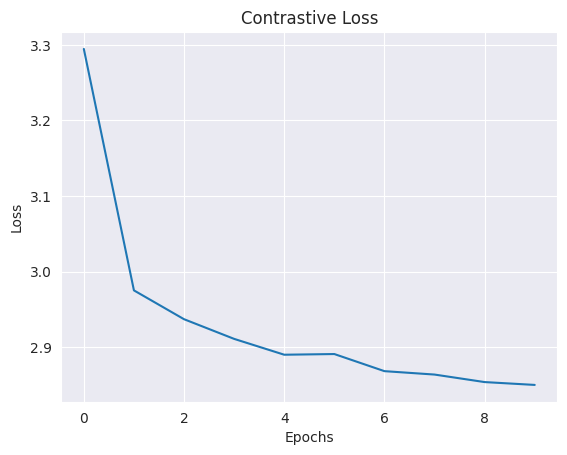

In [44]:
plt.plot(loss_history)
plt.title('Contrastive Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## Classification Head


### Usual MLP

In [45]:
%%capture
# Set random seed for reproducibility
torch.manual_seed(42)

# Define transformation to convert CIFAR-10 images to grayscale
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
train_dataset_mlp = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_mlp = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Define data loaders
batch_size_mlp = 64

In [46]:
%%capture
# Calculate the mean and std of the subset dataset
train_means_mlp, train_stds_mlp = get_mean_std(train_dataset_mlp)
print(f'Means: {train_means_mlp}')
print(f'Standard deviations: {train_stds_mlp}\n')
val_means_mlp, val_stds_mlp = get_mean_std(test_dataset_mlp)
print(f'Validation means: {val_means_mlp}')
print(f'Validation standard deviations: {val_stds_mlp}')

In [47]:
%%capture
train_dataset_mlp = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means_mlp,train_stds_mlp))
val_dataset_mlp = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means_mlp,val_stds_mlp))

# Data Loader
train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=batch_size_mlp, shuffle=True, num_workers=2)
test_loader_mlp = DataLoader(val_dataset_mlp, batch_size=batch_size_mlp, shuffle=False, num_workers=2)

#### Our SimCLR model with MLP Head

In [48]:
%%capture
clr_base_model = SimpleResNet()
clr_base_model.load_state_dict(torch.load(model_name+'.pth'))
clr_base_model.eval()

In [49]:
class MLPHead(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the full model with contrastive feature extractor and MLP head
class ContrastiveMLPModel(nn.Module):
    def __init__(self, feature_extractor, mlp_head):
        super(ContrastiveMLPModel, self).__init__()
        self.base_model = feature_extractor
        self.mlp_model = mlp_head

    def forward(self, x):
        features = self.base_model(x)
        return self.mlp_model(features.view(features.size(0), -1))

In [50]:
%%capture
# Output size of base model: torch.Size([1, 512])
input_size_for_mlp = 512

# Define the MLP head for classification
mlp_head = MLPHead(input_size_for_mlp, hidden_size=256, num_classes=10)

# Combine the feature extractor and MLP head into the full model
contrastive_mlp_model = ContrastiveMLPModel(clr_base_model, mlp_head)
contrastive_mlp_model.base_model.requires_grad = False

# Define the optimizer
mlp_lr = 0.001
optimizer = torch.optim.Adam(contrastive_mlp_model.mlp_model.parameters(), lr=mlp_lr)
criterion = nn.CrossEntropyLoss()

# Define the training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
contrastive_mlp_model.to(device)

In [51]:
for epoch in range(num_epochs):
    contrastive_mlp_model.train()
    total_classification_loss = 0

    for i, data in enumerate(train_loader_mlp):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients only for the parameters that require grad (MLP head)
        contrastive_mlp_model.zero_grad()

        # Forward pass
        predictions = contrastive_mlp_model(images)

        # Calculate classification loss using CrossEntropyLoss
        classification_loss = criterion(predictions, labels)
        total_classification_loss += classification_loss.item()


        # Backward pass and update weights for the MLP head only
        classification_loss.backward()
        optimizer.step()

    average_classification_loss = total_classification_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Classification Loss: {average_classification_loss}')

print('Training finished.')

Epoch 1/10, Classification Loss: 0.6146322797298431
Epoch 2/10, Classification Loss: 0.5672034719467163
Epoch 3/10, Classification Loss: 0.5518818436145783
Epoch 4/10, Classification Loss: 0.542935531949997
Epoch 5/10, Classification Loss: 0.5352910989284515
Epoch 6/10, Classification Loss: 0.5297916806697845
Epoch 7/10, Classification Loss: 0.5254642563343048
Epoch 8/10, Classification Loss: 0.5212735776424408
Epoch 9/10, Classification Loss: 0.5178605819702149
Epoch 10/10, Classification Loss: 0.5145853198051452
Training finished.


In [52]:
contrastive_mlp_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_mlp, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = contrastive_mlp_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

mlp_accuracy = correct / total_samples
print(f'Test Accuracy: {mlp_accuracy}')

Testing: 100%|██████████| 157/157 [00:07<00:00, 20.17it/s]

Test Accuracy: 0.4108


### Using a more complex architecture of FC layers

In [53]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define transformation to convert CIFAR-10 images to grayscale
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 dataset
train_dataset_fc = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_fc = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [54]:
# Calculate the mean and std of the subset dataset
train_means_fc, train_stds_fc = get_mean_std(train_dataset_fc)
print(f'Means: {train_means_fc}')
print(f'Standard deviations: {train_stds_fc}\n')
val_means_fc, val_stds_fc = get_mean_std(test_dataset_fc)
print(f'Validation means: {val_means_fc}')
print(f'Validation standard deviations: {val_stds_fc}')

==> Computing mean and std..
Means: tensor([0.4914, 0.4822, 0.4465])
Standard deviations: tensor([0.2023, 0.1994, 0.2010])

==> Computing mean and std..
Validation means: tensor([0.4942, 0.4851, 0.4504])
Validation standard deviations: tensor([0.2020, 0.1991, 0.2011])


In [55]:
%%capture
# Apply transformations
train_dataset_fc = datasets.CIFAR10(root='./data', train=True, download=True, transform=get_transforms(train_means_fc,train_stds_fc))
val_dataset_fc = datasets.CIFAR10(root='./data', train=False, download=True, transform=get_transforms(val_means_fc,val_stds_fc))

# Data Loader
train_loader_fc = DataLoader(train_dataset_fc, batch_size=batch_size_mlp, shuffle=True, num_workers=2)
test_loader_fc = DataLoader(val_dataset_fc, batch_size=batch_size_mlp, shuffle=False, num_workers=2)

#### Our SimCLR model with FC Head

In [56]:
%%capture
clr_base_model_for_fc = SimpleResNet()
clr_base_model_for_fc.load_state_dict(torch.load(model_name+'.pth'))
clr_base_model_for_fc.eval()

In [57]:
class FCHead(nn.Module):
    def __init__(self, input_size=512, num_classes=10):
        super(FCHead, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ContrastiveFCModel(nn.Module):
    def __init__(self, feature_extractor, fc_head):
        super(ContrastiveFCModel, self).__init__()
        self.base_model = feature_extractor
        self.fc_model = fc_head

    def forward(self, x):
        features = self.base_model(x)
        return self.fc_model(features.view(features.size(0), -1))

In [58]:
%%capture
# Define the CNN head for classification
fc_head = FCHead(input_size=512, num_classes=10)

# Combine the feature extractor and MLP head into the full model
contrastive_fc_model = ContrastiveFCModel(clr_base_model_for_fc, fc_head)
contrastive_fc_model.base_model.requires_grad = False

# Define the optimizer
mlp_lr = 0.001
optimizer = torch.optim.Adam(contrastive_fc_model.fc_model.parameters(), lr=mlp_lr)
criterion = nn.CrossEntropyLoss()

# Define the training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
contrastive_fc_model.to(device)

In [59]:
# Training loop
for epoch in range(num_epochs):
    contrastive_fc_model.train()
    total_classification_loss = 0

    for i, data in enumerate(train_loader_fc):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # Zero the gradients only for the parameters that require grad (FC head)
        contrastive_fc_model.zero_grad()

        # Forward pass
        predictions = contrastive_fc_model(images)

        # Calculate classification loss using CrossEntropyLoss
        classification_loss = criterion(predictions, labels)
        total_classification_loss += classification_loss.item()

        # Backward pass and update weights for the FC head only
        classification_loss.backward()
        optimizer.step()

    average_classification_loss = total_classification_loss / len(train_loader)

    print(f'Epoch {epoch + 1}/{num_epochs}, Classification Loss: {average_classification_loss}')

print('Training finished.')

Epoch 1/10, Classification Loss: 0.5858645562648773
Epoch 2/10, Classification Loss: 0.558238417673111
Epoch 3/10, Classification Loss: 0.5484469312191009
Epoch 4/10, Classification Loss: 0.5416579977512359
Epoch 5/10, Classification Loss: 0.5360598414421082
Epoch 6/10, Classification Loss: 0.5309843094825745
Epoch 7/10, Classification Loss: 0.5283968874931335
Epoch 8/10, Classification Loss: 0.5249115033149719
Epoch 9/10, Classification Loss: 0.522894117641449
Epoch 10/10, Classification Loss: 0.5199760732173919
Training finished.


In [60]:
# Evaluate on the test set
contrastive_fc_model.eval()
correct = 0
total_samples = 0

with torch.no_grad():
    for data in tqdm(test_loader_fc, desc='Testing'):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = contrastive_fc_model(images)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total_samples += labels.size(0)

fc_accuracy = correct / total_samples
print(f'Test Accuracy: {fc_accuracy}')

Testing: 100%|██████████| 157/157 [00:07<00:00, 20.32it/s]

Test Accuracy: 0.4191


ADD TO CSV

In [70]:
with open('results.csv', 'a') as f:
    f.write(""+str(model_name)+','+str(batch_size)+','+str(np.round(elapsed_time,3))+','+str(np.round(loss_history[-1],3))+','+str(np.round(mlp_accuracy,3))+','+str(np.round(fc_accuracy,3))+'\n')